Variables not found, loading data...
Loading data...
Processing files: ['results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0018.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0019.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0120.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0221.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0222.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0223.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0224.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0225.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0226.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0227.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0228.mat', 'results/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage/0229.mat']
/Users/hwenzhang/matlabprojects/nevis/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_s

TypeError: Animation.save() got an unexpected keyword argument 'bbox_inches'

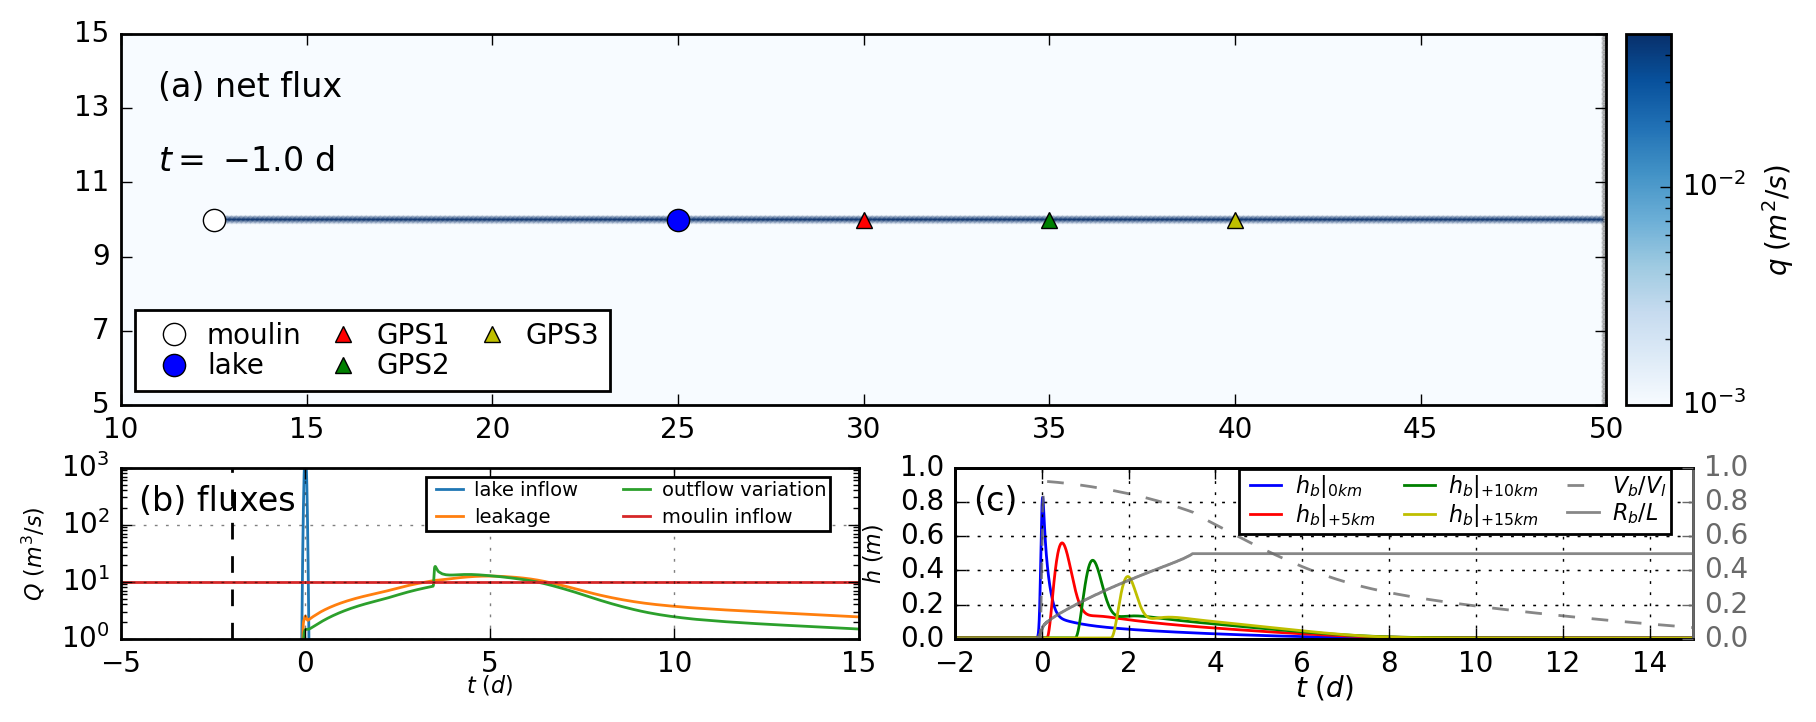

In [ ]:
# The script for 2D animation of NEVIS model results based on the plotting script in test.ipynb
import os
import numpy as np
import subprocess
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Flag to control data import
SKIP_DATA_IMPORT = True
LOAD_NEW_DATA = 0  # Set to True to load new data, False to use existing data
casename = 'n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage'

# Check if key variables already exist
try:
    # Check if main data variables exist and are not empty
    if 'tt' in locals():
        if LOAD_NEW_DATA:
            print("Loading new data as requested...")
            SKIP_DATA_IMPORT = False
        elif tt is not None:
            print("Data already loaded, skipping import section...")
            SKIP_DATA_IMPORT = True
        else:
            print("Variables exist but are None, reloading data...")
            SKIP_DATA_IMPORT = False
    else:
        print("Variables not found, loading data...")
        SKIP_DATA_IMPORT = False
except NameError:
    print("Variables not defined, loading data...")
    SKIP_DATA_IMPORT = False

# -------------------- Parameters for plotting ---------------------------------------------
from cycler import cycler
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442",
             "#0072B2","#D55E00","#CC79A7","#000000"]
colors = okabe_ito
colors = plt.get_cmap('tab10').colors  

xa = 10 
xb = 50
ya = 5
yb = 15
plot_hb = False
plot_qs = True
h_min = 0  # min water thickness on the color bar (m)
h_max = 0.1  # max water thickness on the color bar (m)
q_min = 1e-3 # min water flux on the color bar (m^2/s)
q_max = 5e-2 # max water flux on the color bar (m^2/s)
norm = LogNorm(vmin=q_min, vmax=q_max)

# Time range for drainage
tdrainage_d = 2.0 * 365 + 20
tmin  = tdrainage_d - 5
tmax  = tdrainage_d + 5
tmin_d = tmin 
tmax_d = tmax
# time frame for animation
tslice = tdrainage_d + np.arange(-2, 10, 1)  # days

if (not SKIP_DATA_IMPORT) or (LOAD_NEW_DATA):
    print("Loading data...")
    # ------------------------- Import data -----------------------------------

    mat_path = os.path.join('results', casename, casename + '.mat')
    raw      = sio.loadmat(mat_path, squeeze_me=True)

    tt = raw['tt']
    ps = raw['ps']
    pp = raw['pp']
    oo = raw['oo']
    pd = raw['pd']
    aa = raw['aa']
    gg = raw['gg']

    # 将关键参数转换为数值类型
    ps_t   = np.float64(ps['t'])
    pd_td  = np.float64(pd['td'])
    ps_hb  = np.float64(ps['hb'])
    ps_h   = np.float64(ps['h'])
    ps_x   = np.float64(ps['x'])
    ps_m   = np.float64(ps['m'])
    ps_S   = np.float64(ps['S'])
    ps_phi = np.float64(ps['phi'])
    ps_Q0  = np.float64(ps['Q0'])
    ps_Q   = np.float64(ps['Q'])
    ps_qs  = np.float64(ps['qs'])
    ps_qb  = np.float64(ps['qb'])

    pp_c8 = np.float64(pp['c8'])
    # 同样将 tt 中的数据转换为数值类型
    tt_t      = np.float64(tt['t'])
    tt_Qb_in  = np.float64(tt['Qb_in'])
    tt_Qb_dec = np.float64(tt['Qb_dec'])
    tt_Q_outb = np.float64(tt['Q_outb'])
    tt_Q_outQ = np.float64(tt['Q_outQ'])
    tt_Q_outq = np.float64(tt['Q_outq'])
    tt_E      = np.float64(tt['E'])

    # --- Compute time vectors -----------------------------------------------
    t = (ps_t / (24*60*60)) * tt_t        # days

    # --- Build derived quantities -------------------------------------------
    Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
    Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_b = ps_Q0 * tt_Q_outb
    Q_out_Q = ps_Q  * tt_Q_outQ
    Q_out_q = ps_Q  * tt_Q_outq
    E       = ps_m * ps_x**2 * tt_E

    pts_ni = np.int64(oo['pts_ni'].item())
    phi_0 = ps_phi * np.float64(aa['phi_0'].item())
    pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
    pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
    pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
    pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
    pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])
    pts_hc_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hc']])
    pts_hs_lake    = ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hs']])

    # gps elevations
    #     14 15 16 17    18   19
    #.    8  9  10 11    12   13
    #.    2  3  4   5     6   7
    #.  -1km 0 5km 10km 15km 20km
    pts_hb_gps1 = ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hb']])
    pts_hb_gps2 = ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hb']])
    pts_hb_gps3 = ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hb']])
    pts_hb_gps4 = ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hb']])

    pts_hc_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hc']])
    pts_hc_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hc']])
    pts_hc_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hc']])
    pts_hc_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hc']])

    pts_hs_gps1 = ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in tt['pts_hs']])
    pts_hs_gps2 = ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in tt['pts_hs']])
    pts_hs_gps3 = ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in tt['pts_hs']])
    pts_hs_gps4 = ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in tt['pts_hs']])

    N = ps_phi * np.float64(tt['N'])  # MPa
    pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
    pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

    V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
    V_c = ps_x    * ps_S  * np.float64(tt['S'])
    V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])
    R_b = ps_x * np.float64(tt['Rb'])

    # 对空间变量进行转换
    xx = ps_x/1e3 * np.float64(gg['nx'].item())
    yy = ps_x/1e3 * np.float64(gg['ny'].item())
    nI = int(gg['nI'].item())
    nJ = int(gg['nJ'].item())
    eI = int(gg['eI'].item())
    eJ = int(gg['eJ'].item())
    cI = int(gg['cI'].item())
    cJ = int(gg['cJ'].item())

    nmeanx = gg['nmeanx'].item()
    nmeany = gg['nmeany'].item()
    nmeans = gg['nmeans'].item()
    nmeanr = gg['nmeanr'].item()
    ein = gg['ein'].item()
    fin = gg['fin'].item()
    cin = gg['cin'].item()
    Dx = np.float64(gg['Dx'].item())
    Dy = np.float64(gg['Dy'].item())
    Ds = np.float64(gg['Ds'].item())
    Dr = np.float64(gg['Dr'].item())

    # --- get spatial pattern at different times -----------------------------
    tspan = ps_t/pd_td*oo['t_span']
    nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

    # run matlab script to extend the field for times
    filenames = [os.path.join('results', casename, f"{num:04d}.mat") for num in nums]
    print(f"Processing files: {filenames}")
    # save the filenames to a text file
    # Save filenames and casename to a .mat file for MATLAB to load
    filenames_array = np.array(filenames, dtype=object)
    sio.savemat('extend_field.mat', {
        'filenames': filenames_array,
        'casename': casename
    })
    # Use MATLAB’s -batch option to run the script and auto‐exit when done
    matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
    subprocess.run([
        matlab_path,
        "-nodisplay",
        "-nosplash",
        "-nodesktop",
        "-batch",
        "nevis_nodedischarge_python"
    ], check=True)

    vhb = []
    vphi1 = []
    vhs = []
    vhc = []
    vt = []
    vqs = []
    vqe = []
    vqQ = []
    vqb = []

    for i in range(len(nums)):
        con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
        raw_con = sio.loadmat(con_path, squeeze_me=True)

        vv = raw_con['vv']
        vv2 = raw_con['vv2']

        # geometry values
        phi1_val = np.float64(vv['phi'].item())
        hb_val   = np.float64(vv['hb'].item())
        hs_val   = np.float64(vv['hs'].item())
        pb_val   = np.float64(vv['pb'].item())

        Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
        Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
        Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
        Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

        vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
        vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
        vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
        vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
        vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
        vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
        vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
        vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
        vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
        vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))

        # flux values
        qs_val = np.float64(vv2['qs'].item())
        qe_val = np.float64(vv2['qe'].item())
        qQ_val = np.float64(vv2['qQ'].item())
        qb_val = np.float64(vv2['qb'].item())
        vqs.append(np.array(np.reshape(qs_val, (nI, nJ), order='F'), dtype=np.float64))
        vqe.append(np.array(np.reshape(qe_val, (nI, nJ), order='F'), dtype=np.float64))
        vqQ.append(np.array(np.reshape(qQ_val, (nI, nJ), order='F'), dtype=np.float64))
        vqb.append(np.array(np.reshape(qb_val, (nI, nJ), order='F'), dtype=np.float64))
    vt = np.array(vt, dtype=np.float64)-tdrainage_d

# ================= Plotting setup ======================================
fig = plt.figure(figsize=(10, 4), dpi=300)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.style.use('classic')
plt.rc('axes', prop_cycle=cycler('color', colors))
plt.rcParams["figure.dpi"] = 600
# plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0:2, 0:2])
cmap = plt.cm.Blues
divider2 = make_axes_locatable(ax1)
cax1 = divider2.append_axes("right", size="3%", pad=0.1)
# Create a color mesh for the total water thickness
if plot_hb:
    pc = ax1.pcolormesh(xx, yy,
                        ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
elif plot_qs:
    pc = ax1.pcolormesh(xx, yy,
                        ps_qs * vqs[1] + ps_qb * vqb[1] + ps_qs * vqQ[1],  # 使用最后一个时间步
                        cmap=cmap, norm=norm, shading='gouraud')
    pc.set_edgecolor('face')
else:
    print("No valid plot type selected. Please set plot_hb or plot_qs to True.")

# Add color bar
cbar = fig.colorbar(pc, cax=cax1, orientation='vertical')
cbar.ax.set_ylabel('$h\\;(m)$' if plot_hb else '$q\\;(m^2/s)$', fontsize=10)
cbar.ax.tick_params(labelsize=10)   

# Plot contour lines for the blister alone
hcontour_lines = ax1.contour(xx, yy, ps_hb * vhb[1], levels=[0.01], colors='blue', linewidths=1.0, linestyles='-')
phicontour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='k', linewidths=0.5, linestyles='-')

ax1.plot(12.5, 10, 'wo', markersize=8, label='moulin')
ax1.plot(25.0, 10, 'bo', markersize=8, label='lake')
ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')

ax1.text(0.025, 0.9, '(a) net flux', transform=ax1.transAxes,
         ha='left', va='top', fontsize=12, clip_on=False)
time = ax1.text(0.025, 0.7, '$t=$ '+ f'${vt[1]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=12, clip_on=False, color='black')
ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
ax1.set_xticks(np.arange(xa, xb + 1, 5))
ax1.set_yticks(np.arange(ya, yb + 1, 2))
ax1.set_xticklabels(np.arange(xa, xb + 1, 5), fontsize=10)
ax1.set_yticklabels(np.arange(ya, yb + 1, 2), fontsize=10)
ax1.set_aspect('equal')
ax1.legend(loc='lower left', fontsize=10, frameon=True, handletextpad=0.2, ncol=3, labelspacing=0.1, numpoints=1, columnspacing=0.5)

# ============== Panel (b): Flux (last row: spanning both columns) ==============
ax2 = fig.add_subplot(gs[2, 0])

ax2.plot(t-tdrainage_d, Q_b_in, '-',    linewidth=1.0, label='lake inflow')
ax2.plot(t-tdrainage_d, Q_b_dec,'-',    linewidth=1.0, label='leakage')
ax2.plot(t-tdrainage_d, Q_out_b + Q_out_Q + Q_out_q - E, '-', linewidth=1.0, label=r'outflow variation')
ax2.plot(t-tdrainage_d, E,       '-',    linewidth=1.0, label='moulin inflow')
ax2time = ax2.axvline(x=vt[0], color='k', linestyle='--', linewidth=1.0)
ax2.set_yscale('log')
ax2.set_xlim(tmin_d-tdrainage_d, tmax_d-tdrainage_d+10)
ax2.set_xlabel('$t~(d)$')
ax2.xaxis.set_label_coords(0.5, -0.2)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)
ax2.set_ylim(1e0, 1e3)
ax2.set_ylabel(r'$Q~(m^3/s)$')
ax2.text(0.025, 0.9, '(b) fluxes', transform=ax2.transAxes,
         ha='left', va='top', fontsize=12, clip_on=False)
ax2.legend(loc='upper left',  bbox_to_anchor=(0.4, 1.0), frameon=True, fontsize=7, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax2.grid(alpha=0.5)

# ============== Panel (c): total volume and thickness ==============
ax3 = fig.add_subplot(gs[2, 1])
ax3.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_ax3  = ax3.get_position()
ax3_width = pos_ax3.x1 - pos_ax3.x0
ax3_pos = [pos_ax3.x0+0.03*ax3_width, pos_ax3.y0, ax3_width, pos_ax3.y1 - pos_ax3.y0]

# Create new axes with the calculated positions
ax3 = fig.add_axes(ax3_pos)
# ============== Plot thickness ==============
ax3.plot(t-tdrainage_d, ps_hb*pts_hb_lake + ps_h*(pts_hc_gps1+pts_hs_gps1), 'b-', linewidth=1.0, label='$h_b|_{0km}$', alpha=1.0)
ax3.plot(t-tdrainage_d, ps_hb*pts_hb_gps2 + ps_h*(pts_hc_gps2+pts_hs_gps2), 'r-', linewidth=1.0, label='$h_b|_{+5km}$', alpha=1.0)
ax3.plot(t-tdrainage_d, ps_hb*pts_hb_gps3 + ps_h*(pts_hc_gps3+pts_hs_gps3), 'g-', linewidth=1.0, label='$h_b|_{+10km}$', alpha=1.0)
ax3.plot(t-tdrainage_d, ps_hb*pts_hb_gps4 + ps_h*(pts_hc_gps4+pts_hs_gps4), 'y-', linewidth=1.0, label='$h_b|_{+15km}$', alpha=1.0)

ax3time = ax3.axvline(x=vt[0], color='k', linestyle='--', linewidth=1.0)
ax3.set_xlim(tmin_d+3-tdrainage_d, tmax_d+10-tdrainage_d)
ax3.set_xlabel('$t~(d)$', fontsize=10)
ax3.xaxis.set_label_coords(0.5, -0.2)
ax3.tick_params(axis='y', labelsize=10)
ax3.tick_params(axis='x', labelsize=10)
ax3.set_ylim(0, 1.0)
ax3.set_ylabel(r'$h~(m)$')
ax3.text(0.025, 0.9, '(c)', transform=ax3.transAxes,
         ha='left', va='top', fontsize=12, clip_on=False)
# ax3.legend(loc='lower left',  bbox_to_anchor=(0.1, -0.7), frameon=True, fontsize=8, ncol=4,
#            labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax3.grid(alpha=1.0)

# ============== Plot volume ==============
ax3_twin = ax3.twinx()
ax3_twin.plot(t-tdrainage_d, V_b/1e7, '--', color='dimgray', linewidth=1.0, label='$V_b/V_l$', alpha=0.8)
ax3_twin.plot(t-tdrainage_d, R_b/5e4, '-', color='dimgray', linewidth=1.0, label='$R_b/L$', alpha=0.8)

ax3_twin.set_xlabel('$t~(d)$', fontsize=10)
# ax3_twin.set_ylabel(r'$V_b/V_l$', fontsize=8)
ax3_twin.set_ylim(0, 1.0)
ax3_twin.tick_params(axis='y', labelsize=10)
ax3_twin.grid(alpha=0.5)
# make axis and label blue
ax3_twin.spines['right'].set_color('dimgray')
ax3_twin.yaxis.label.set_color('dimgray')
ax3_twin.tick_params(axis='y', colors='dimgray')

# combine legend entries from ax3 and its twin
handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax3_twin.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left',
    bbox_to_anchor=(0.37, 1.06), fontsize=8, ncol=3,
    labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
    frameon=True, framealpha=1.0)

# animate the figure by updating the pcolormesh and contour
import matplotlib.animation as animation

def init():
    global history_lines, history_pcs
    history_lines = []
    history_pcs = []
    # 清除所有现有的等高线
    for collection in ax1.collections[1:]:  # 跳过第一个pcolormesh
        collection.remove()
    return []

def update(frame):
    global hcontour_lines, phicontour_lines
    # 更新 pcolormesh 数据
    if plot_hb:
        pc.set_array((ps_hb * vhb[frame] + ps_h * vhs[frame] + ps_h * vhc[frame]).ravel())
    elif plot_qs:
        pc.set_array((ps_qs * vqs[frame] + ps_qb * vqb[frame] + ps_qs * vqQ[frame]).ravel())

    # 先检查 contour 是否已经有对象

    for collection in ax1.collections[1:]:  # 跳过第一个(pcolormesh)
        collection.remove()

    hcontour_lines = ax1.contour(xx, yy, ps_hb * vhb[frame],    levels=[0.01],
                          colors='blue', linewidths=1.0, linestyles='-')
    phicontour_lines = ax1.contour(xx, yy, ps_phi/1e6 * vphi1[frame],
                          colors='k',    linewidths=0.5, linestyles='-')
    # update the text
    time.set_text('(b) $t=$ '+ f'${vt[frame]:.1f}$ d')
    # update the vertical dashed line
    ax2time.set_xdata([vt[frame], vt[frame]])
    ax3time.set_xdata([vt[frame], vt[frame]])

HISTORY_STEPS = 3 
ALPHA_DECAY = 0.15  
history_lines = []  
history_pcs = []

def update(frame):
    global history_lines, history_pcs
    
    # 降低现有历史 pcolormesh 的透明度
    for old_pc in history_pcs:
        alpha = old_pc.get_alpha() if old_pc.get_alpha() is not None else 1.0
        old_pc.set_alpha(alpha * ALPHA_DECAY * 2)
    
    # 移除太旧的 pcolormesh
    while len(history_pcs) >= HISTORY_STEPS:
        old_pc = history_pcs.pop(0)
        old_pc.remove()
    
    # 创建新的 pcolormesh
    if plot_hb:
        new_data = ps_hb * vhb[frame] + ps_h * vhs[frame] + ps_h * vhc[frame]
    elif plot_qs:
        new_data = ps_qs * vqs[frame] + ps_qb * vqb[frame] + ps_qs * vqQ[frame]
    
    new_pc = ax1.pcolormesh(xx, yy, new_data, 
                           cmap=cmap, norm=norm, 
                           shading='gouraud',
                           alpha=1.0)
    new_pc.set_edgecolor('face')
    history_pcs.append(new_pc)

    # 降低现有历史等高线的透明度
    for contours in history_lines:
        for contour in contours:
            alpha = contour.get_alpha() if contour.get_alpha() is not None else 1.0
            contour.set_alpha(alpha * ALPHA_DECAY)

    # 移除太旧的等高线
    while len(history_lines) >= HISTORY_STEPS:
        old_contours = history_lines.pop(0)
        for contour in old_contours:
            contour.remove()

    # 绘制新的等高线
    hcontours = ax1.contour(xx, yy, ps_hb * vhb[frame], 
                           levels=[0.01],
                           colors='blue', 
                           linewidths=1.0, 
                           linestyles='-')
    phicontours = ax1.contour(xx, yy, ps_phi/1e6 * vphi1[frame],
                             colors='k', 
                             linewidths=0.5, 
                             linestyles='-')
    
    # 将新的等高线添加到历史记录中
    # QuadContourSet 对象本身就是一个集合，直接存储它们
    history_lines.append([hcontours, phicontours])

    # 更新时间标签和垂直线
    time.set_text('$t=$ '+ f'${vt[frame]:.1f}$ d')
    ax2time.set_xdata([vt[frame], vt[frame]])
    ax3time.set_xdata([vt[frame], vt[frame]])

    # 返回所有需要更新的艺术家对象
    artists = [time, ax2time, ax3time]
    artists.extend(history_pcs)
    for contours in history_lines:
        artists.extend(contours)
    return artists

ani = animation.FuncAnimation(fig, update, frames=len(nums), init_func=init, blit=False)
ani.save('summertime.gif', writer='pillow', fps=2, dpi=300,  pad_inches=0.3)
plt.show()


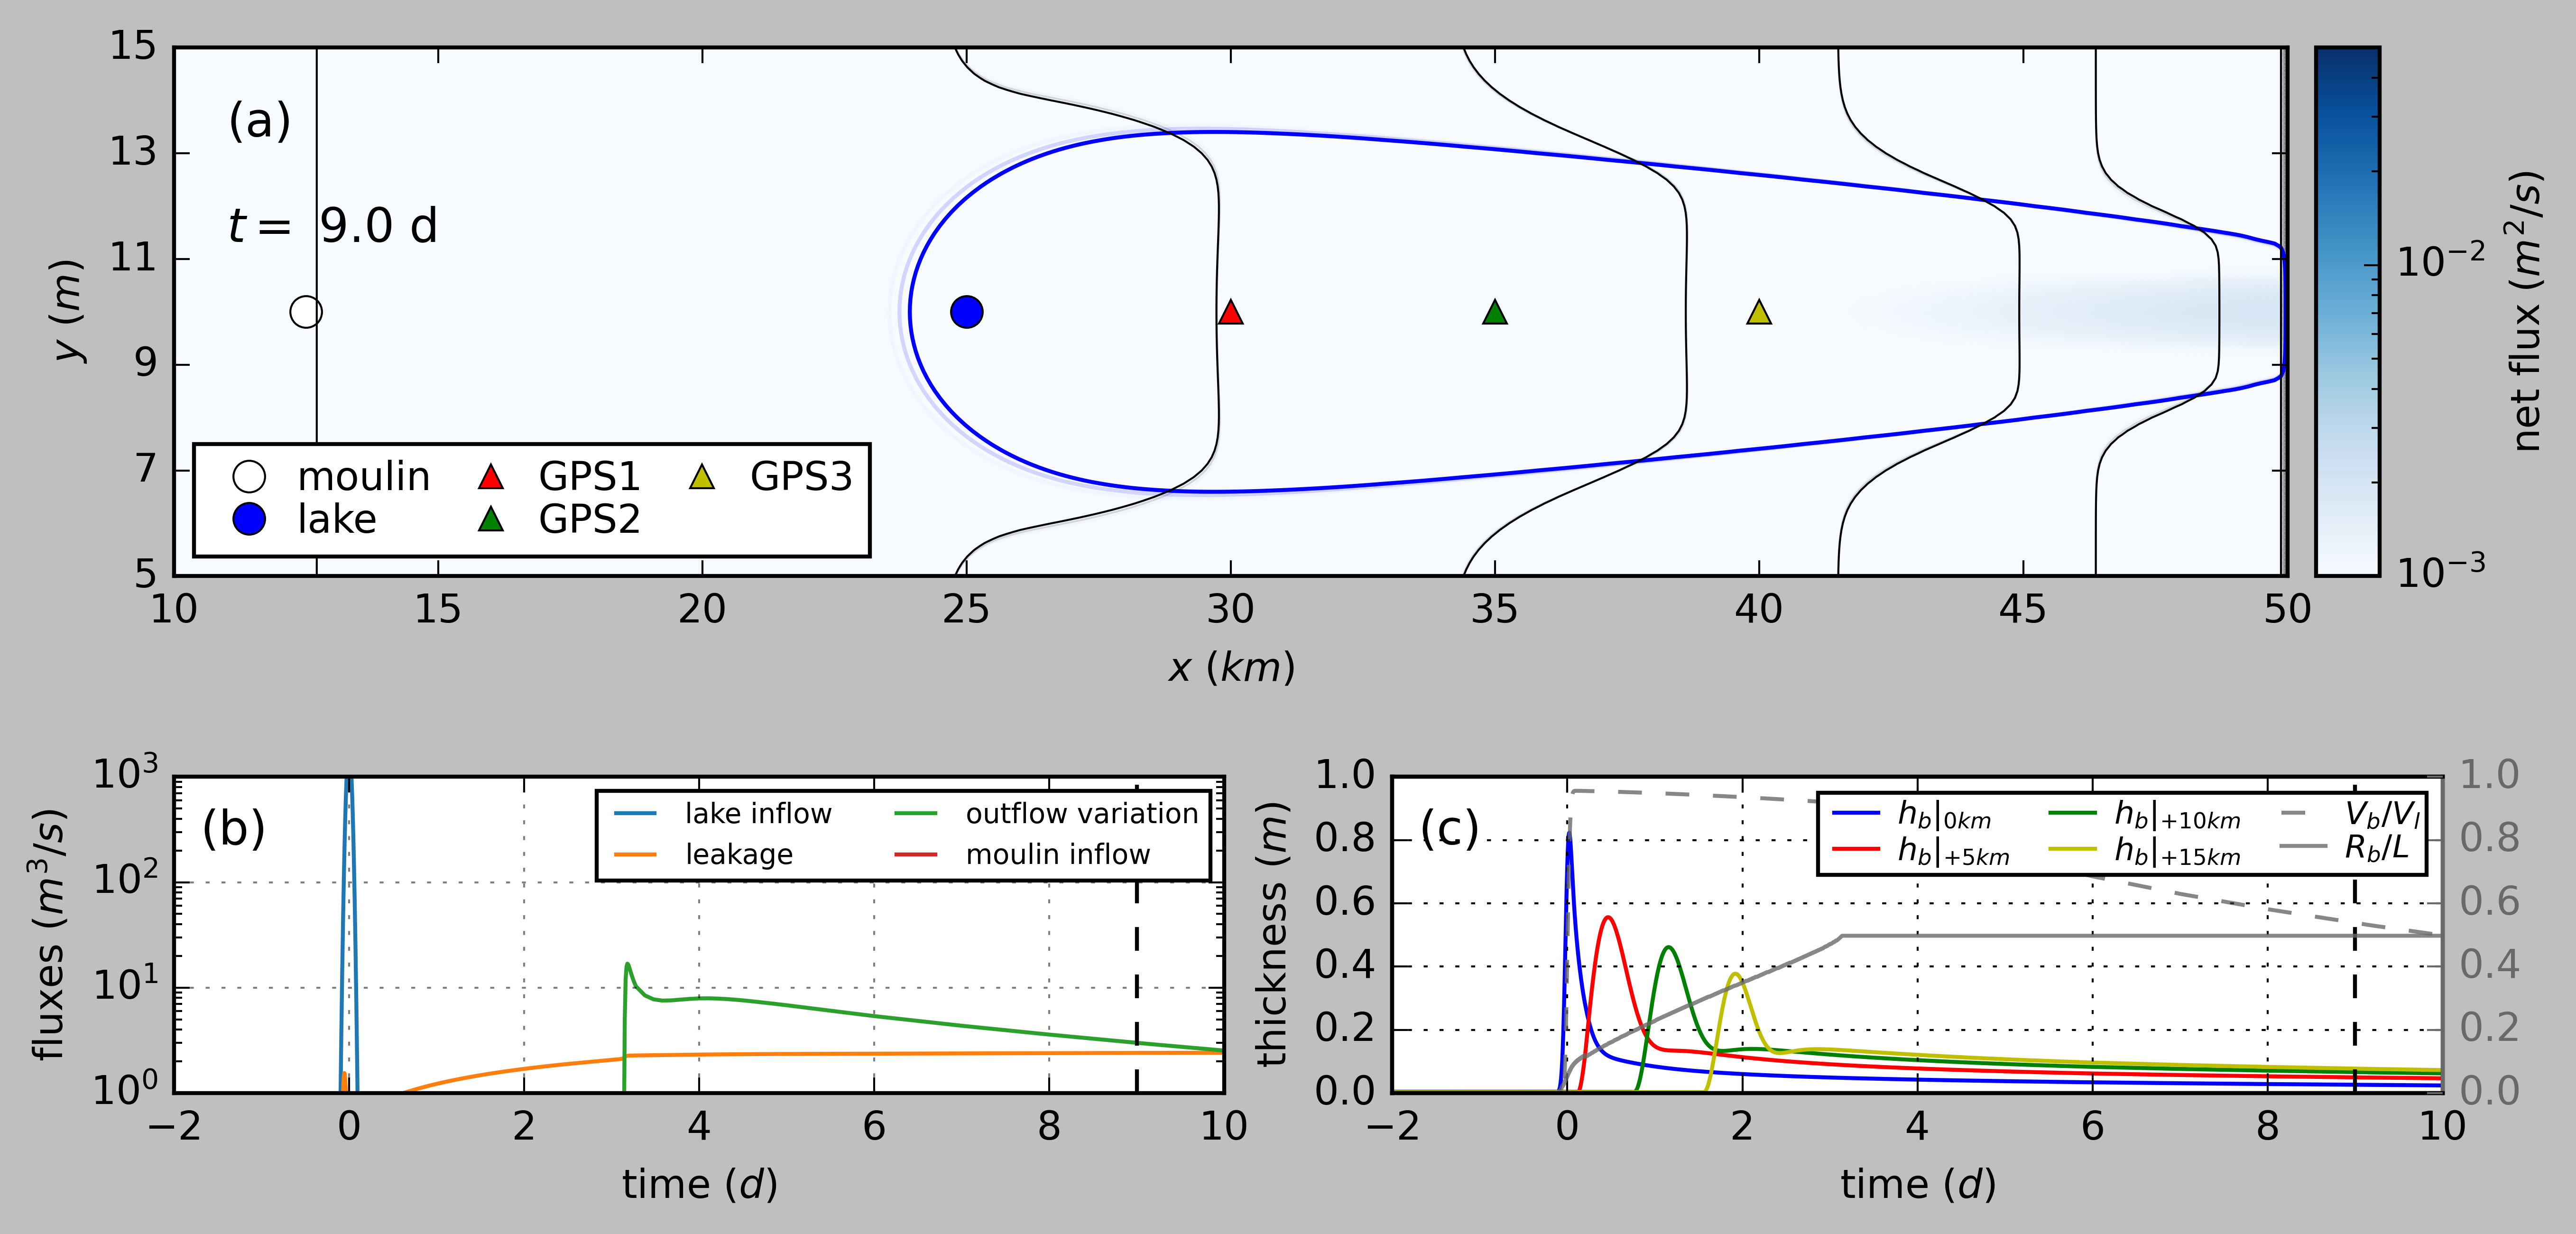

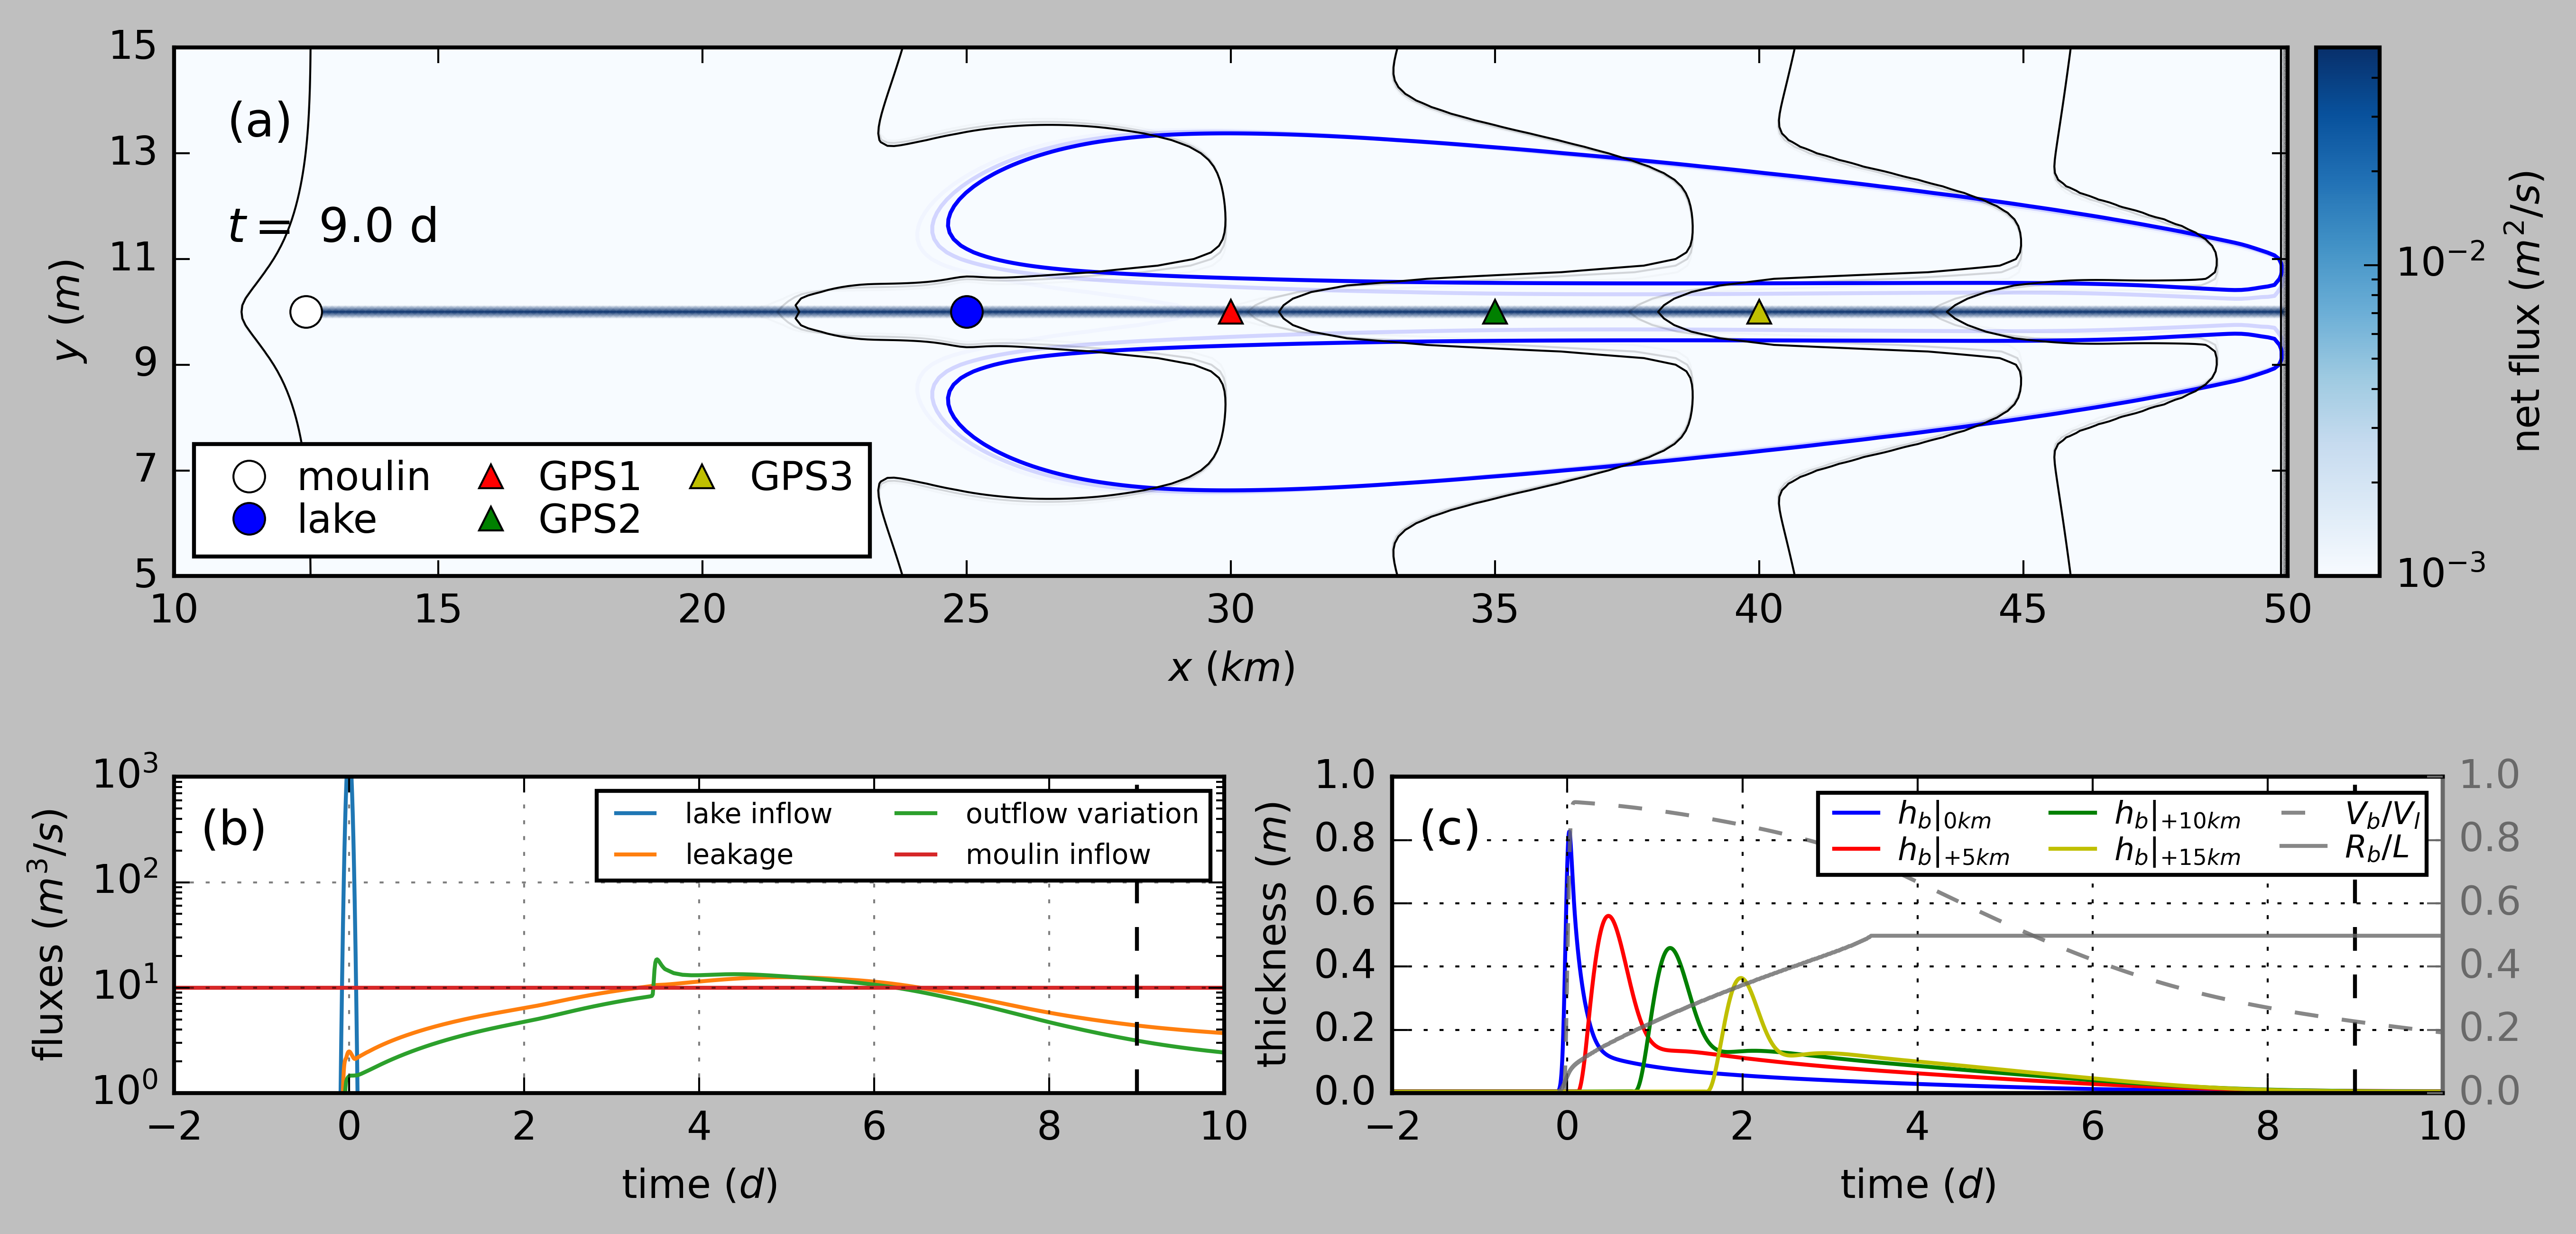

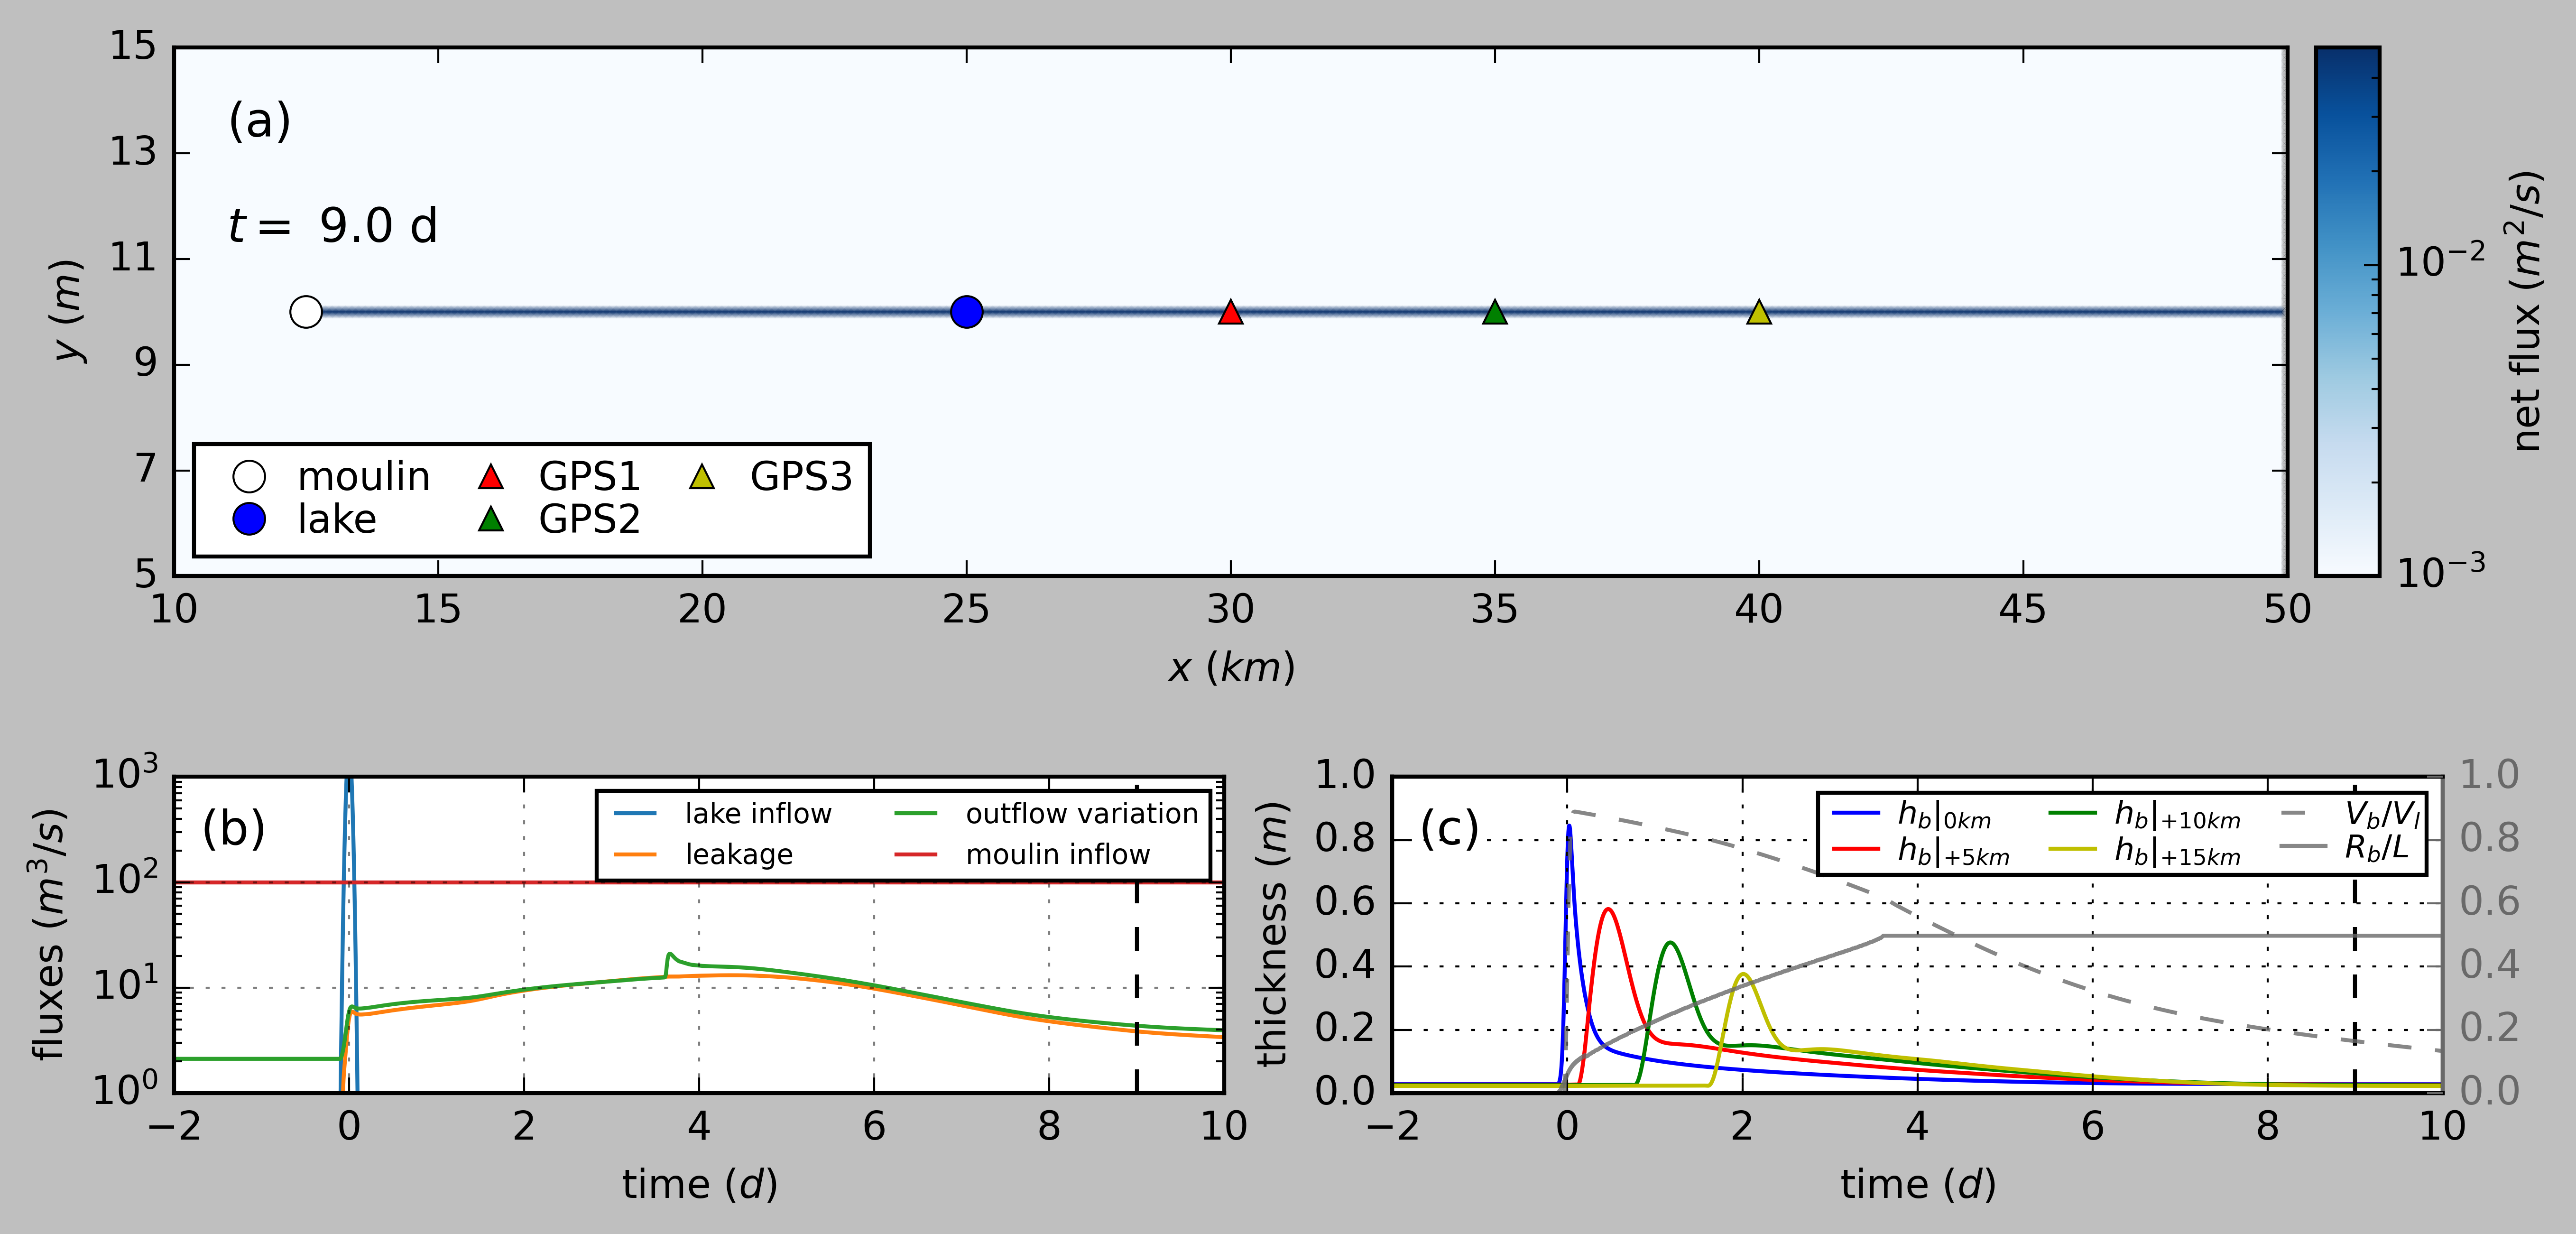

In [16]:
import os
import numpy as np
import subprocess
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation, PillowWriter
from cycler import cycler

class NevisAnimation:
    def __init__(self, casename, tslice, plot_type='qs'):
        """
        initialize the nevis animation

        parameters:
        casename: str, casename
        tslice: array-like, time slice for the animation
        plot_type: str, 'hb' or 'qs', controls whether to plot water thickness or flux
        """
        self.casename = casename
        self.tslice = tslice
        self.plot_type = plot_type
        
        # animation parameters
        self.HISTORY_STEPS = 3
        self.ALPHA_DECAY = 0.15
        
        # plotting parameters
        self.xa, self.xb = 10, 50
        self.ya, self.yb = 5, 15
        self.q_min, self.q_max = 1e-3, 5e-2
        self.h_min, self.h_max = 0, 0.1
        self.t_drainage = 750
        # initialize storage containers
        self.history_lines = []
        self.history_pcs = []

        # load data
        self._load_data()
        
    def _load_data(self):
        """load and process MATLAB data"""
        # Load main data file
        mat_path = os.path.join('results', self.casename, f'{self.casename}.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)

        # Extract key data structures
        self.tt = raw['tt']
        self.ps = raw['ps']
        self.pp = raw['pp']
        self.oo = raw['oo']
        self.pd = raw['pd']
        self.aa = raw['aa']
        self.gg = raw['gg']

        # Convert parameters to numeric types
        self._convert_parameters()

        # Compute time vectors
        self._compute_time_vectors()

        # Load spatial pattern data
        self._load_spatial_patterns()
        
    def _setup_figure(self):
        """set up figure and axes"""
        self.fig = plt.figure(figsize=(10, 5), dpi=300)
        gs = gridspec.GridSpec(3, 2, figure=self.fig, wspace=0.1, hspace=0.3)

        # set up plotting style
        plt.style.use('classic')
        colors = plt.get_cmap('tab10').colors
        plt.rc('axes', prop_cycle=cycler('color', colors))
        plt.rcParams["figure.dpi"] = 600
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['mathtext.fontset'] = 'dejavusans'
        plt.rcParams['font.size'] = 8

        # create subplots
        self._setup_main_panel(gs)
        self._setup_flux_panel(gs)
        self._setup_volume_panel(gs)
        
    def _update(self, frame):
        """update animation frame"""
        # update history pcolormesh
        self._update_pcolormesh_history(frame)

        # update history contours
        self._update_contour_history(frame)

        # update time labels and vertical lines
        self._update_time_indicators(frame)

        # return updated artist objects
        return self._get_artists()
        
    def create_animation(self, output_filename, fps=2):
        """create and save animation"""
        self._setup_figure()

        # create animation object
        ani = FuncAnimation(
            self.fig,
            self._update,
            frames=len(self.nums),
            init_func=self._init,
            blit=False
        )

        # save animation
        writer = PillowWriter(fps=fps)
        ani.save(output_filename, writer=writer, dpi=300)
        
        return ani
    
    def _init(self):
        """initialize animation"""
        self.history_lines = []
        self.history_pcs = []
        for collection in self.ax1.collections[1:]:
            collection.remove()
        return []

    def _update_pcolormesh_history(self, frame):
        """update pcolormesh history effect"""
        # reduce opacity of existing history
        for old_pc in self.history_pcs:
            alpha = old_pc.get_alpha() if old_pc.get_alpha() is not None else 1.0
            old_pc.set_alpha(alpha * self.ALPHA_DECAY * 2)

        # remove too old history
        while len(self.history_pcs) >= self.HISTORY_STEPS:
            old_pc = self.history_pcs.pop(0)
            old_pc.remove()

        # create new pcolormesh
        if self.plot_type == 'hb':
            new_data = (self.ps_hb * self.vhb[frame] + 
                       self.ps_h * self.vhs[frame] + 
                       self.ps_h * self.vhc[frame])
        else:
            new_data = (self.ps_qs * self.vqs[frame] + 
                       self.ps_qb * self.vqb[frame] + 
                       self.ps_qs * self.vqQ[frame])
        
        new_pc = self.ax1.pcolormesh(
            self.xx, self.yy, new_data,
            cmap=self.cmap,
            norm=self.norm,
            shading='gouraud',
            alpha=1.0
        )
        new_pc.set_edgecolor('face')
        self.history_pcs.append(new_pc)

    def _update_contour_history(self, frame):
        """update contour history effect"""
        # reduce opacity of existing history
        for contours in self.history_lines:
            for contour in contours:
                alpha = contour.get_alpha() if contour.get_alpha() is not None else 1.0
                contour.set_alpha(alpha * self.ALPHA_DECAY)

        # remove too old history
        while len(self.history_lines) >= self.HISTORY_STEPS:
            old_contours = self.history_lines.pop(0)
            for contour in old_contours:
                contour.remove()

        # create new contours
        hcontours = self.ax1.contour(
            self.xx, self.yy,
            self.ps_hb * self.vhb[frame],
            levels=[0.01],
            colors='blue',
            linewidths=1.0,
            linestyles='-'
        )
        
        phicontours = self.ax1.contour(
            self.xx, self.yy,
            self.ps_phi/1e6 * self.vphi1[frame],
            colors='k',
            linewidths=0.5,
            linestyles='-'
        )
        
        self.history_lines.append([hcontours, phicontours])
    def _convert_parameters(self):
        """Convert parameters from MATLAB data structures to numpy arrays"""
        # Convert parameters from ps structure
        self.ps_t = np.float64(self.ps['t'])
        self.pd_td = np.float64(self.pd['td'])
        self.ps_hb = np.float64(self.ps['hb'])
        self.ps_h = np.float64(self.ps['h'])
        self.ps_x = np.float64(self.ps['x'])
        self.ps_m = np.float64(self.ps['m'])
        self.ps_S = np.float64(self.ps['S'])
        self.ps_phi = np.float64(self.ps['phi'])
        self.ps_Q0 = np.float64(self.ps['Q0'])
        self.ps_Q = np.float64(self.ps['Q'])
        self.ps_qs = np.float64(self.ps['qs'])
        self.ps_qb = np.float64(self.ps['qb'])
        
        # Convert parameters from pp structure
        self.pp_c8 = np.float64(self.pp['c8'])
        
        # Convert time series data
        self.tt_t = np.float64(self.tt['t'])
        self.tt_Qb_in = np.float64(self.tt['Qb_in'])
        self.tt_Qb_dec = np.float64(self.tt['Qb_dec'])
        self.tt_Q_outb = np.float64(self.tt['Q_outb'])
        self.tt_Q_outQ = np.float64(self.tt['Q_outQ'])
        self.tt_Q_outq = np.float64(self.tt['Q_outq'])
        self.tt_E = np.float64(self.tt['E'])

        # Convert grid parameters
        self.xx = self.ps_x/1e3 * np.float64(self.gg['nx'].item())
        self.yy = self.ps_x/1e3 * np.float64(self.gg['ny'].item())
        self.nI = int(self.gg['nI'].item())
        self.nJ = int(self.gg['nJ'].item())
        self.eI = int(self.gg['eI'].item())
        self.eJ = int(self.gg['eJ'].item())
        self.cI = int(self.gg['cI'].item())
        self.cJ = int(self.gg['cJ'].item())

        # Add point data conversions
        pts_ni = np.int64(self.oo['pts_ni'].item())
        phi_0 = self.ps_phi * np.float64(self.aa['phi_0'].item())
        
        # Convert point data from time series
        self.pts_phi_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_phi']])
        self.pts_phi_moulin = self.ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_phi']])
        self.pts_hb_lake = self.ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_moulin = self.ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_hb']])
        self.pts_pb_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_pb']])
        self.pts_hc_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hc']])
        self.pts_hs_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hs']])

        # GPS elevations data
        self.pts_hb_gps1 = self.ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps2 = self.ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps3 = self.ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps4 = self.ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hb']])

        self.pts_hc_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hc']])

        self.pts_hs_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hs']])

        # Additional derived quantities
        self.N = self.ps_phi * np.float64(self.tt['N'])  # MPa
        self.pts_N_lake = np.float64(phi_0[pts_ni][0] - self.pts_phi_lake)
        self.pts_N_moulin = np.float64(phi_0[pts_ni][1] - self.pts_phi_moulin)

        self.V_b = self.ps_x**2 * self.ps_hb * np.float64(self.tt['Vb'])
        self.V_c = self.ps_x * self.ps_S * np.float64(self.tt['S'])
        self.V_s = self.ps_x**2 * self.ps_h * np.float64(self.tt['hs'])
        self.R_b = self.ps_x * np.float64(self.tt['Rb'])

    def _compute_time_vectors(self):
        """Compute time vectors and related quantities"""
        # Compute base time vector
        self.t = (self.ps_t / (24*60*60)) * self.tt_t  # days
        
        # Compute derived quantities
        self.Q_b_in = np.float64(self.pd['Q_0']) * self.tt_Qb_in
        self.Q_b_dec = self.ps_h * self.ps_x**2 / self.ps_t * self.tt_Qb_dec
        
        self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
        self.Q_out_Q = self.ps_Q * self.tt_Q_outQ
        self.Q_out_q = self.ps_Q * self.tt_Q_outq
        self.E = self.ps_m * self.ps_x**2 * self.tt_E

        # Get time points for animation
        tspan = self.ps_t/self.pd_td*self.oo['t_span']
        self.nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in self.tslice])

    def _load_spatial_patterns(self):
        """Load spatial patterns for each time step"""
        # Initialize arrays
        self.vhb, self.vphi1, self.vhs = [], [], []
        self.vhc, self.vt = [], []
        self.vqs, self.vqe, self.vqQ, self.vqb = [], [], [], []

        # Get mesh operators needed for channel calculations
        nmeanx = self.gg['nmeanx'].item()
        nmeany = self.gg['nmeany'].item()
        nmeans = self.gg['nmeans'].item()
        nmeanr = self.gg['nmeanr'].item()
        Dx = np.float64(self.gg['Dx'].item())
        Dy = np.float64(self.gg['Dy'].item())
        Ds = np.float64(self.gg['Ds'].item())
        Dr = np.float64(self.gg['Dr'].item())

        # Check if ALL files have vv2
        need_preprocessing = False
        for num in self.nums:
            con_path = os.path.join('results', self.casename, f"{num:04d}.mat")
            if os.path.exists(con_path):
                raw_con = sio.loadmat(con_path, squeeze_me=True)
                if 'vv2' not in raw_con:
                    need_preprocessing = True
                    break
            else:
                need_preprocessing = True
                break

        # Run MATLAB preprocessing if needed
        if need_preprocessing:
            print("vv2 missing in some files, running MATLAB preprocessing...")
            filenames = [os.path.join('results', self.casename, f"{num:04d}.mat") for num in self.nums]
            filenames_array = np.array(filenames, dtype=object)
            sio.savemat('extend_field.mat', {
                'filenames': filenames_array,
                'casename': self.casename
            })
            matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
            subprocess.run([
                matlab_path,
                "-nodisplay",
                "-nosplash",
                "-nodesktop",
                "-batch",
                "nevis_nodedischarge_python"
            ], check=True)

        # Process each time step
        for num in self.nums:
            con_path = os.path.join('results', self.casename, f"{num:04d}.mat")
            raw_con = sio.loadmat(con_path, squeeze_me=True)

            vv = raw_con['vv']
            vv2 = raw_con['vv2']
            
            # Load geometry values
            phi1_val = np.float64(vv['phi'].item())
            hb_val = np.float64(vv['hb'].item())
            hs_val = np.float64(vv['hs'].item())
            
            # Calculate channel thickness - THIS WAS MISSING!
            Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
            Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
            Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
            Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))
            hc_val = self.pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy)
            
            # Reshape and append values
            self.vphi1.append(np.reshape(phi1_val, (self.nI, self.nJ), order='F'))
            self.vhb.append(np.reshape(hb_val, (self.nI, self.nJ), order='F'))
            self.vhs.append(np.reshape(hs_val, (self.nI, self.nJ), order='F'))
            self.vhc.append(np.reshape(hc_val, (self.nI, self.nJ), order='F'))  # ADD THIS LINE

            # Load and append flux values
            self.vqs.append(np.reshape(np.float64(vv2['qs'].item()), (self.nI, self.nJ), order='F'))
            self.vqe.append(np.reshape(np.float64(vv2['qe'].item()), (self.nI, self.nJ), order='F'))
            self.vqQ.append(np.reshape(np.float64(vv2['qQ'].item()), (self.nI, self.nJ), order='F'))
            self.vqb.append(np.reshape(np.float64(vv2['qb'].item()), (self.nI, self.nJ), order='F'))
            
            # Compute and append time values
            self.vt.append((self.ps_t / self.pd_td) * np.float64(vv['t'].item()))
        
        # Convert time list to array and adjust relative to drainage time
        self.vt = np.array(self.vt) - self.t_drainage

    def _setup_main_panel(self, gs):
        """Setup main visualization panel"""
        # Create main axes
        self.ax1 = self.fig.add_subplot(gs[0:2, 0:2])
        self.cmap = plt.cm.Blues
        
        # Add colorbar
        divider = make_axes_locatable(self.ax1)
        self.cax1 = divider.append_axes("right", size="3%", pad=0.1)
        
        # Create initial pcolormesh
        if self.plot_type == 'hb':
            data = (self.ps_hb * self.vhb[0] + 
                    self.ps_h * self.vhs[0] + 
                    self.ps_h * self.vhc[0])
            self.norm = LogNorm(vmin=self.h_min, vmax=self.h_max)
        else:
            data = (self.ps_qs * self.vqs[0] + 
                    self.ps_qb * self.vqb[0] + 
                    self.ps_qs * self.vqQ[0])
            self.norm = LogNorm(vmin=self.q_min, vmax=self.q_max)
        
        self.pc = self.ax1.pcolormesh(
            self.xx, self.yy, data,
            cmap=self.cmap,
            norm=self.norm,
            shading='gouraud'
        )
        self.pc.set_edgecolor('face')
        
        # Add colorbar
        self.cbar = self.fig.colorbar(self.pc, cax=self.cax1, orientation='vertical')
        ylabel = '$h\\;(m)$' if self.plot_type == 'hb' else 'net flux$\\;(m^2/s)$'
        self.cbar.ax.set_ylabel(ylabel, fontsize=10)
        self.cbar.ax.tick_params(labelsize=10)
        
        # Add markers
        self.ax1.plot(12.5, 10, 'wo', markersize=8, label='moulin')
        self.ax1.plot(25.0, 10, 'bo', markersize=8, label='lake')
        self.ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
        self.ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
        self.ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')
        
        # Add text and set limits
        self.ax1.text(0.025, 0.9, '(a)', transform=self.ax1.transAxes,
                    ha='left', va='top', fontsize=12, clip_on=False)
        self.time_text = self.ax1.text(0.025, 0.7, '', transform=self.ax1.transAxes,
                                    ha='left', va='top', fontsize=12, clip_on=False)
        
        self.ax1.set_xlim(self.xa, self.xb)
        self.ax1.set_ylim(self.ya, self.yb)
        self.ax1.set_xticks(np.arange(self.xa, self.xb + 1, 5))
        self.ax1.set_yticks(np.arange(self.ya, self.yb + 1, 2))
        self.ax1.tick_params(axis='both', labelsize=10)
        self.ax1.set_xlabel('$x~(km)$',fontsize=10)
        self.ax1.set_ylabel('$y~(m)$',fontsize=10)
        self.ax1.set_aspect('equal')
        
        # Add legend
        self.ax1.legend(loc='lower left', fontsize=10, frameon=True,
                        handletextpad=0.2, ncol=3, labelspacing=0.1, numpoints=1, columnspacing=0.5)

    def _setup_flux_panel(self, gs):
        """Setup flux panel"""
        self.ax2 = self.fig.add_subplot(gs[2, 0])
        self.ax2.set_visible(False)  # Hide original axes
        # Get positions of ax2
        pos_ax2  = self.ax2.get_position()
        ax2_width = pos_ax2.x1 - pos_ax2.x0
        ax2_height = pos_ax2.y1 - pos_ax2.y0
        ax2_pos = [pos_ax2.x0, pos_ax2.y0-0.02*ax2_height, ax2_width, ax2_height]
        self.ax2 = self.fig.add_axes(ax2_pos)

        self.ax2.plot(self.t-self.t_drainage, self.Q_b_in, '-', 
                    linewidth=1.0, label='lake inflow')
        self.ax2.plot(self.t-self.t_drainage, self.Q_b_dec, '-',
                    linewidth=1.0, label='leakage')
        self.ax2.plot(self.t-self.t_drainage, 
                    self.Q_out_b + self.Q_out_Q + self.Q_out_q - self.E, '-',
                    linewidth=1.0, label='outflow variation')
        self.ax2.plot(self.t-self.t_drainage, self.E, '-',
                    linewidth=1.0, label='moulin inflow')
        
        # Add vertical time indicator
        self.ax2time = self.ax2.axvline(x=self.vt[0], color='k',
                                    linestyle='--', linewidth=1.0)
        
        self.ax2.set_yscale('log')
        self.ax2.set_xlabel(r'time $(d)$', fontsize=10)
        self.ax2.set_ylabel(r'fluxes $(m^3/s)$', fontsize=10)
        self.ax2.tick_params(axis='both', labelsize=10)
        self.ax2.set_ylim(1e0, 1e3)
        self.ax2.set_xlim(-2,10)
        
        self.ax2.text(0.025, 0.9, '(b)', transform=self.ax2.transAxes,
                    ha='left', va='top', fontsize=12)
        self.ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                        frameon=True, fontsize=7, ncol=2)
        self.ax2.grid(alpha=0.5)

    def _setup_volume_panel(self, gs):
        """Setup volume panel"""
        self.ax3 = self.fig.add_subplot(gs[2, 1])
        self.ax3.set_visible(False)  # Hide original axes

        # Get positions of ax3
        pos_ax3  = self.ax3.get_position()
        ax3_width = pos_ax3.x1 - pos_ax3.x0
        ax3_height = pos_ax3.y1 - pos_ax3.y0
        ax3_pos = [pos_ax3.x0+0.06*ax3_width, pos_ax3.y0-0.02*ax3_height, ax3_width, ax3_height]
        self.ax3 = self.fig.add_axes(ax3_pos)
        # Plot thickness lines
        self.ax3.plot(self.t-self.t_drainage, 
                    self.ps_hb*self.pts_hb_lake + self.ps_h*(self.pts_hc_gps1+self.pts_hs_gps1),
                    'b-', linewidth=1.0, label='$h_b|_{0km}$')
        self.ax3.plot(self.t-self.t_drainage,
                    self.ps_hb*self.pts_hb_gps2 + self.ps_h*(self.pts_hc_gps2+self.pts_hs_gps2),
                    'r-', linewidth=1.0, label='$h_b|_{+5km}$')
        self.ax3.plot(self.t-self.t_drainage,
                    self.ps_hb*self.pts_hb_gps3 + self.ps_h*(self.pts_hc_gps3+self.pts_hs_gps3),
                    'g-', linewidth=1.0, label='$h_b|_{+10km}$')
        self.ax3.plot(self.t-self.t_drainage,
                    self.ps_hb*self.pts_hb_gps4 + self.ps_h*(self.pts_hc_gps4+self.pts_hs_gps4),
                    'y-', linewidth=1.0, label='$h_b|_{+15km}$')

        # Add vertical time indicator
        self.ax3time = self.ax3.axvline(x=self.vt[0], color='k',
                                    linestyle='--', linewidth=1.0)
        
        self.ax3.set_xlabel(r'time $(d)$',fontsize=10)
        self.ax3.set_ylabel(r'thickness $(m)$', fontsize=10)
        self.ax3.tick_params(axis='both', labelsize=10)
        self.ax3.set_ylim(0, 1.0)
        self.ax3.set_xlim(-2, 10)
        
        self.ax3.text(0.025, 0.9, '(c)', transform=self.ax3.transAxes,
                    ha='left', va='top', fontsize=12)
        self.ax3.grid(alpha=1.0)
        
        # Add twin axis for volume
        self.ax3_twin = self.ax3.twinx()
        self.ax3_twin.plot(self.t-self.t_drainage, self.V_b/1e7, '--',
                        color='dimgray', label='$V_b/V_l$', alpha=0.8)
        self.ax3_twin.plot(self.t-self.t_drainage, self.R_b/5e4, '-',
                        color='dimgray', label='$R_b/L$', alpha=0.8)
        
        self.ax3_twin.set_ylim(0, 1.0)
        self.ax3_twin.spines['right'].set_color('dimgray')
        self.ax3_twin.yaxis.label.set_color('dimgray')
        self.ax3_twin.tick_params(axis='y', colors='dimgray')

        self.ax3_twin.set_xlabel('time $(d)$', fontsize=10)
        self.ax3_twin.set_ylim(0, 1.0)
        self.ax3_twin.tick_params(axis='y', labelsize=10)
        self.ax3_twin.grid(alpha=0.5)

        # combine legend entries from ax3 and its twin
        handles1, labels1 = self.ax3.get_legend_handles_labels()
        handles2, labels2 = self.ax3_twin.get_legend_handles_labels()
        plt.legend(handles1 + handles2, labels1 + labels2, loc='upper right',
            bbox_to_anchor=(1.00, 1.00), fontsize=8, ncol=3,
            labelspacing=0.1, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
            frameon=True, framealpha=1.0)

    def _update_time_indicators(self, frame):
        """Update time indicators on all panels"""
        self.time_text.set_text('$t=$ '+ f'${self.vt[frame]:.1f}$ d')
        self.ax2time.set_xdata([self.vt[frame], self.vt[frame]])
        self.ax3time.set_xdata([self.vt[frame], self.vt[frame]])

    def _get_artists(self):
        """Return list of artists that need updating"""
        artists = [self.time_text, self.ax2time, self.ax3time]
        artists.extend(self.history_pcs)
        for contours in self.history_lines:
            artists.extend(contours)
        return artists
    
casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_100m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage']
# casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage']
tdrainage_d = 2.0 * 365 + 20
tslice = tdrainage_d + np.arange(-1, 10, 1.0)

for casename in casenames:
    animator = NevisAnimation(casename, tslice, plot_type='qs')
    ani = animator.create_animation('./presentation/animation/'+casename+'.gif', fps=1)